In [1]:
#imports
import numpy as np
import os
import tempfile
import keras
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Conv2D, Add, Reshape
from keras.models import Sequential
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from keras.utils.vis_utils import plot_model
from keras.callbacks import History 
from keras.models import load_model
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.layers import Concatenate
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import random
import datetime
from termcolor import colored

from keras.activations import softmax 
print("import loads done")

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


import loads done


In [38]:
def model_1dconv(window_size, filter_len, n_inp_series=1, n_output=1, n_filter=4):
    model= Sequential()
    model.add(Conv1D(filters= n_filter, kernel_size= filter_len, activation="relu", input_shape=(window_size, n_inp_series)))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters=n_filter, kernel_size=filter_len, activation="relu"))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(n_output, activation="linear"))
    
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [40]:
#run the cell if want to progress using 1d conv model
model= model_1dconv(window_size=50, filter_len= 3, n_inp_series=5, n_output=5, n_filter=4)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 48, 4)             64        
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 24, 4)             0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 22, 4)             52        
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 11, 4)             0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 44)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 225       
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [20]:
datapath= "blast_tab_1hit.out"

file= open(datapath, 'r')

train_entries=[]
val_entries= []
test_entries=[]
max_length_in =0
max_length_out=0
ynoise_train=[]
ynoise_val=[]
ynoise_test=[]

np.random.seed(0)

for ln in file:
    toks=ln.split('\t')
    rand_num= np.random.random()
    
    if(toks[2] != toks[3]):
        max_length_in= max(max_length_in, len(toks[2]))
        max_length_out= max(max_length_out, len(toks[3]))
        
        if rand_num< 0.95:
            train_entries.append([toks[2], toks[3]])
            ynoise_train.append([1])
        elif rand_num < 0.975:
            test_entries.append([toks[2], toks[3]])
            ynoise_test.append([1])
        else:
            val_entries.append([toks[2], toks[3]])
            ynoise_val.append([1])
    
    if(toks[2]== toks[3]):
        if rand_num > 0.975:
            val_entries.append([toks[2], toks[3]])
            ynoise_val.append([0])
        elif rand_num > 0.95:
            test_entries.append([toks[2], toks[3]])
            ynoise_test.append([0])
        elif rand_num > 0.9:
            train_entries.append([toks[2], toks[3]])
            ynoise_train.append([0])
            
file.close()

label_train_noise= np.array(ynoise_train)
label_test_noise= np.array(ynoise_test)
label_val_noise= np.array(ynoise_val)

one_hot_input = {'A': 0, 'T': 1, 'C': 2, 'G': 3, '-': 4}
one_hot_output = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
            


In [21]:
#print shapes:
print("labels shape")
print("y_train: ", label_train_noise.shape)
print("y_test: ", label_test_noise.shape)
print("y_val: ", label_val_noise.shape)

labels shape
y_train:  (77510, 1)
y_test:  (12107, 1)
y_val:  (12269, 1)


In [22]:
#visualize labels
num_vis= 100
print("visualize labels for noisy vs non-noisy")
print("y_train")
print(label_train_noise[0:num_vis])
print("y_val")
print(label_val_noise[0:num_vis])
print("y_test")
print(label_test_noise[0:num_vis])

visualize labels for noisy vs non-noisy
y_train
[[1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
y_val
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]


In [23]:
#visualize data entries
n_peek=10
print("data entries:")
print("train")
print(train_entries[n_peek])

print("test")
print(test_entries[n_peek])

print("val")
print(val_entries[n_peek])

data entries:
train
['ACCGACGGCCCGAGTGGTGGCCACTTTTATTGGGCCTAAAGCGTCCGTAGCCGGTCCAGTAAGTCCTTGTTTAAATCCTGCGGCTTAACCGCAGGACTGGCAGGGATACTGCTGGACTTGGGACCGGGAGAGGACAAGGGTACTTCAGGGGTAGCGGTGAAATGTGTTGATCCTTGAAGGACCACCTATGGCGAAGGCACTTGTCTGGAACGGGTCCGACGGTGAGGGACGAAGGCCAGGGGAGCAAACCG', 'ACCGACGGCCCGAGTGGTGGCCACTTTTATTGGGCCTAAAGCGTCCGTAGCCGGTCCAGTAAGTCCTTGTTTAAATCCTGCGGCTTAACCGCAGGACTGGCAGGGATACTGCTGGACTTGGGACCGGGAGAGGACAAGGGTACTTCAGGGGTAGCGGTGAAATGTGTTGATCCTTGAAGGACCACCTATGGCGAAGGCACTTGTCTGGAACGGGTCCGACGGTGAGGGACGAAAGCCAGGGGCGCGAACCG']
test
['ACAGGGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTGCGCAGGCGGATTCATAAGTCGGGGGTTAAATCCATGTGCTTAACACATGCAAGGCTTCCGATACTGTGAGTCTAGAGTCTCGAAGAGGAAGATGGAATTTCCGGTGTAACGGTGGAATGTGTAGATATCGGAAAGAACACCAGTGGCGAAGGCAGTCTTCTGGTCGAGAACTGACGCTCAGGCACGAAAGCGTGGGGAGCAAACAG', 'ACAGGGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTGCGCAGGCGGATTCATAAGTCGGGGGTTAAATCCATGTGCTTAACACATGCAAGGCTTCCGATACTGTGAGTCTAGAGTCTCGAAGAGGAAGATGGAATTTCCGGTGTAACGGTGGAATGTGTAGATATCGGAAAGAACACCAGTGGCGAAGGCAGTCTTCTG

In [24]:
#length of sequences
print("max len inp:", max_length_in)
print("max len out: ", max_length_out)

max len inp: 308
max len out:  308


In [25]:
labels_train=np.array(label_train_noise)
labels_val= np.array(label_val_noise)
labels_test= np.array(label_test_noise)

print("shapes")
print(labels_train.shape)
print(labels_test.shape)
print(labels_val.shape)

shapes
(77510, 1)
(12107, 1)
(12269, 1)


In [26]:
#The next few cells used for data preparation
#for train, val and test data to send inside model

input_seqs= [entry[0] for entry in train_entries]
output_seqs= [entry[1] for entry in train_entries]
val_input_seqs= [entry[0] for entry in val_entries]
val_output_seqs= [entry[1] for entry in val_entries]
test_input_seqs= [entry[0] for entry in test_entries]
test_output_seqs= [entry[1] for entry in test_entries]

In [27]:
print(len(input_seqs))
print(len(val_input_seqs))
print(len(test_input_seqs))

77510
12269
12107


In [28]:
#train val and test data
X_train= np.zeros(
    (len(input_seqs), len(one_hot_input), max_length_in, 1),
    dtype= 'float32')
#print(X_train.shape)
for i, (input_seqs, output_seqs) in enumerate(zip(input_seqs, output_seqs)):
    for t, char in enumerate(input_seqs):
        X_train[i,one_hot_input[char],t,0]=1

In [29]:
#shape and data for X_train
print(X_train.shape)
print(X_train[0:num_vis, :,:,0])

(77510, 5, 308, 1)
[[[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[1. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [30]:
#val data train
X_val= np.zeros(
    (len(val_input_seqs), len(one_hot_input), max_length_in, 1),
    dtype= 'float32')
#print(X_train.shape)
for i, (val_input_seqs, val_output_seqs) in enumerate(zip(val_input_seqs, val_output_seqs)):
    for t, char in enumerate(val_input_seqs):
        X_val[i,one_hot_input[char],t,0]=1

In [31]:
#shape and data for X_val
print(X_val.shape)
print(X_val[0:num_vis, :,:,0])

(12269, 5, 308, 1)
[[[1. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [32]:
X_test= np.zeros(
    (len(test_input_seqs), len(one_hot_input), max_length_in, 1),
    dtype= 'float32')
#print(X_train.shape)
for i, (test_input_seqs, test_output_seqs) in enumerate(zip(test_input_seqs, test_output_seqs)):
    for t, char in enumerate(test_input_seqs):
        X_test[i,one_hot_input[char],t,0]=1

In [33]:
#shape and data for X_test
print(X_test.shape)
print(X_test[0:num_vis, :,:,0])

(12107, 5, 308, 1)
[[[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [34]:
def softMaxAxis1(x):
    return softmax(x,axis=1)


def model_custom(input_shape):
    X_input= Input(input_shape)
    
    X= Conv2D(128, (4,7), strides=(1,1), padding='same', name='conv0')(X_input)
    X= BatchNormalization(axis=3, name='bn0')(X)
    X= Activation('relu')(X)
    
    X= Conv2D(64, (1,7), strides=(1,1), padding='same', name='conv1')(X)
    X= BatchNormalization(axis=3, name='bn1')(X)
    X= Activation('relu')(X)
    
    X= Conv2D(64, (1,7), strides=(1,1), padding='same', name='conv2')(X)
    X= BatchNormalization(axis=3, name='bn2')(X)
    X= Activation('relu')(X)
    
    X= Dropout(0.3, name='dropout')(X)
    
    X= Conv2D(32, (1,7), strides=(1,1), padding='same', name='conv3')(X)
    X= BatchNormalization(axis=3, name='bn3')(X)
    X= Activation('relu')(X)
    
    X= Conv2D(1, (1,1), strides=(1,1), padding='same', name='conv4')(X)
    X= BatchNormalization(axis=3, name='bn4')(X)
    X= Flatten()(X)
    X= Dense(1, activation='sigmoid')(X)
    
    model= Model(inputs=X_input, outputs=X, name='Model1')
    return model
    

In [35]:
#need to pass in parameters from input data
mymodel= model_custom((len(one_hot_input),max_length_in,1))
mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5, 308, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 5, 308, 128)       3712      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 5, 308, 128)       512       
_________________________________________________________________
activation_5 (Activation)    (None, 5, 308, 128)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 5, 308, 64)        57408     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 5, 308, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 5, 308, 64)        0         
__________

In [46]:
#compile model
adam= keras.optimizers.Adam(lr= 0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
mymodel.compile(optimizer=adam, loss= "binary_crossentropy", metrics=["accuracy"])
print("compilation done!")

compilation done!


In [47]:
#run model
history = History()
filepath="seqWeights/ConvNet-test-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
numExamples = 1000
batch_size = 100
epochs = 5
print(X_train.shape)
print((X_train[0:numExamples,:,:,:]).shape)
mymodel.fit(X_train[0:numExamples, :, :,:],
          np.array(labels_train)[0:numExamples],
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val[0:numExamples,:,:,:], np.array(labels_val)[0:numExamples]), verbose = 1,
         callbacks = [history, checkpoint])


(77510, 5, 308, 1)
(1000, 5, 308, 1)
Train on 1000 samples, validate on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 168s 168ms/step - loss: 5.1465 - acc: 0.6490 - val_loss: 2.6738 - val_acc: 0.8340

Epoch 00001: val_acc improved from -inf to 0.83400, saving model to seqWeights/ConvNet-test-01-0.83.hdf5
Epoch 2/5
1000/1000 [==============================] - 165s 165ms/step - loss: 3.6667 - acc: 0.7700 - val_loss: 2.5146 - val_acc: 0.8440

Epoch 00002: val_acc improved from 0.83400 to 0.84400, saving model to seqWeights/ConvNet-test-02-0.84.hdf5
Epoch 3/5
1000/1000 [==============================] - 167s 167ms/step - loss: 3.6667 - acc: 0.7700 - val_loss: 13.1178 - val_acc: 0.1770

Epoch 00003: val_acc did not improve from 0.84400
Epoch 4/5
1000/1000 [==============================] - 165s 165ms/step - loss: 3.6667 - acc: 0.7700 - val_loss: 13.4394 - val_acc: 0.1570

Epoch 00004: val_acc did not improve from 0.84400
Epoch 5/5
1000/1000 [===========================

In [120]:
np.array(labels_val).shape

(12269, 1)

In [48]:
currtime = datetime.datetime.now()
histfname = "./trainHistoryDict_" + currtime.strftime("%m%d-%H%M") + "_5hotNoiseClassification"
with open(histfname, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [49]:
#histfname = "./trainHistoryDict_" + currtime.strftime("%m%d-%H%M") + "_5hotNoiseClassification"
history = pickle.load(open(histfname, "rb" ))

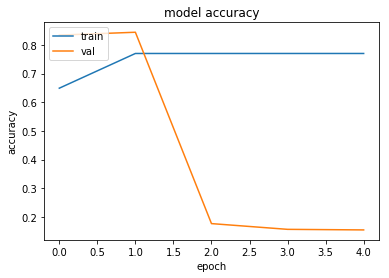

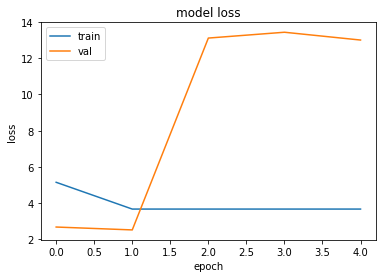

In [50]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()